In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import shap

import math

from lib import *

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
# plt.style.use('dark_background')
sns.set_theme(style="whitegrid", palette="muted")
sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [3]:
WORK_DIR = 'working_data'
FILE_NAME = 'df_work_ds_final.zip'

In [4]:
filepath = Path(f'./{WORK_DIR}/{FILE_NAME}')
df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [5]:
columns_drop = [
    "Fel_1",
    "Fel_2",
    "D_SL",
    "O2_tot",
    "Sl_tot",
    "AC_rbk_open",
    "AC_valve_open",
    "P_O2_in",
    "P_tot_2",
    "FT1_level",
    "FT1_P",
    "FT1_T_in",
    "FT1_T",
    "FT2_level",
    "FT2_P",
    "FT2_T",
    "Cond_Q",
    "Cond_level",
    "Cond_valve",
    "O2_conc_1",
    "O2_conc_2",
    'T_C1',
    'T_C2',
    'T_C3',
    'T_C4',
    'T_C5'
]

df.drop(columns_drop, inplace=True, axis=1)

График измерения железа 2+ до обработки.

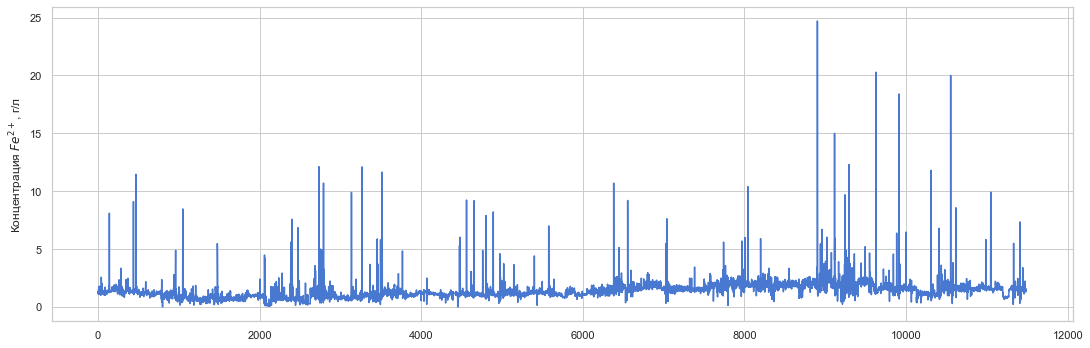

In [6]:
plot_data_rolling(df['Fe2+'], title='Концентрация $Fe^{2+}$, г/л')

Сгладим данные и уберем точки которые на $2\sigma$ отличаются от среднего значения за 12 часов.

In [12]:
for col in df.columns:
    smooth_data_moving_average(df[col], window=12)

Выведем график железа 2+ после обработки.

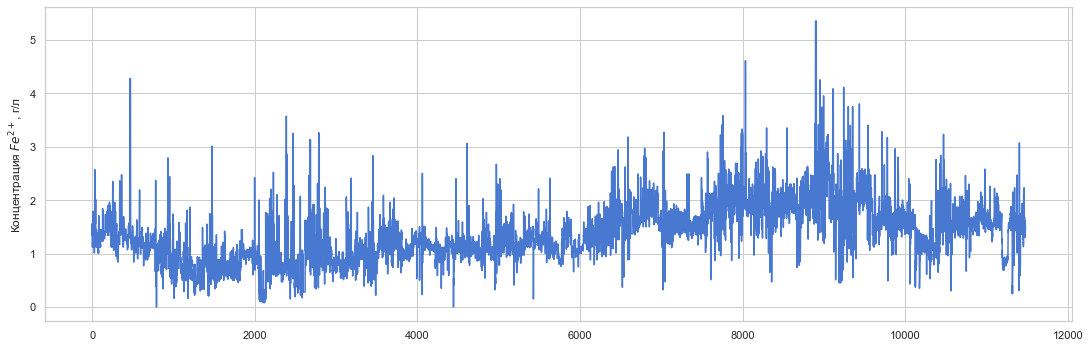

In [13]:
plot_data_rolling(df['Fe2+'], title='Концентрация $Fe^{2+}$, г/л')

Используем модель CatBoost для предсказания значений Fe2+. Все будем использовать аналогично Sample_model

In [14]:
df['Fe2+_corr'] = df['Fe2+'].shift(2)

df.dropna(axis=0, inplace=True)

df['lag_1'] = df['Fe2+_corr'].shift(1)
df['lag_2'] = df['Fe2+_corr'].shift(2)
df['lag_3'] = df['Fe2+_corr'].shift(3)
df['lag_4'] = df['Fe2+_corr'].shift(4)
df['lag_5'] = df['Fe2+_corr'].shift(5)

df.dropna(axis=0, inplace=True)

In [15]:
X = df.drop(['Fe2+', 'Fe2+_corr'], axis=1)
y = df['Fe2+_corr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

In [16]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(train_data)

Learning rate set to 0.057913
0:	learn: 0.5216429	total: 14ms	remaining: 14s
1:	learn: 0.5030490	total: 25.4ms	remaining: 12.7s
2:	learn: 0.4852528	total: 36.2ms	remaining: 12s
3:	learn: 0.4693267	total: 45.4ms	remaining: 11.3s
4:	learn: 0.4537572	total: 54.2ms	remaining: 10.8s
5:	learn: 0.4392680	total: 64.5ms	remaining: 10.7s
6:	learn: 0.4262974	total: 72.5ms	remaining: 10.3s
7:	learn: 0.4129299	total: 82.4ms	remaining: 10.2s
8:	learn: 0.4014555	total: 93.4ms	remaining: 10.3s
9:	learn: 0.3901839	total: 101ms	remaining: 10s
10:	learn: 0.3801667	total: 111ms	remaining: 9.95s
11:	learn: 0.3705821	total: 118ms	remaining: 9.75s
12:	learn: 0.3619522	total: 127ms	remaining: 9.61s
13:	learn: 0.3538880	total: 135ms	remaining: 9.48s
14:	learn: 0.3465466	total: 143ms	remaining: 9.4s
15:	learn: 0.3400134	total: 153ms	remaining: 9.4s
16:	learn: 0.3333631	total: 164ms	remaining: 9.47s
17:	learn: 0.3275503	total: 175ms	remaining: 9.53s
18:	learn: 0.3223542	total: 183ms	remaining: 9.44s
19:	learn: 0

Метрики качества
RMSE: 0.2664
MAE: 0.1548
R2: 0.7550


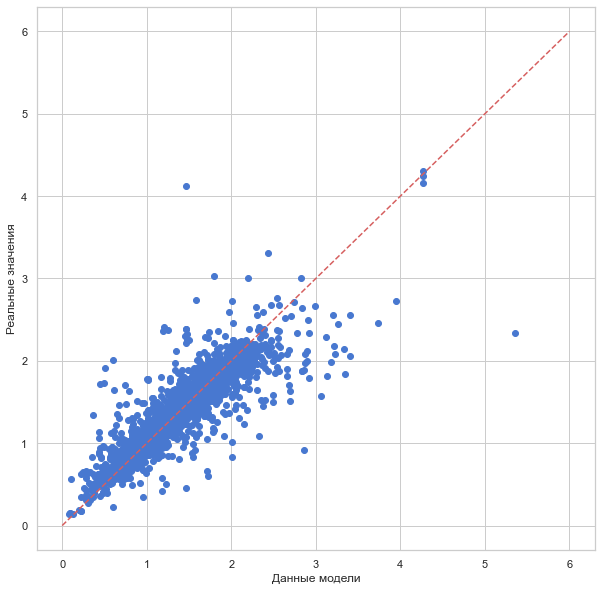

In [32]:
model_score(model, X_test, y_test)

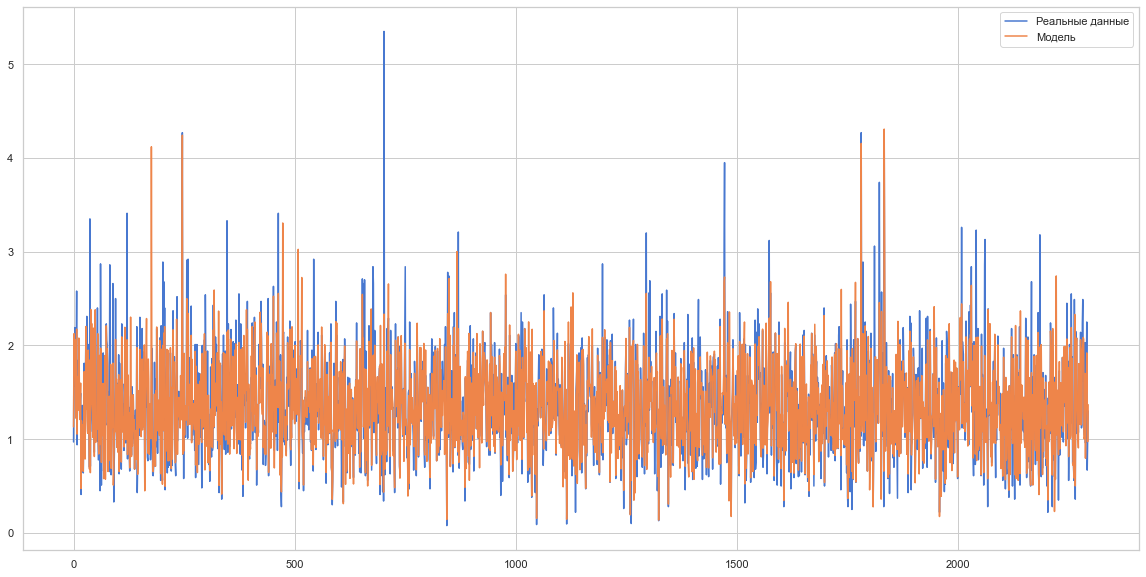

In [34]:
pred = model.predict(X_test)

plt.figure(figsize=(20,10))

plt.plot(y_test.values, label='Реальные данные')
plt.plot(pred, label='Модель')

plt.legend()
plt.show();

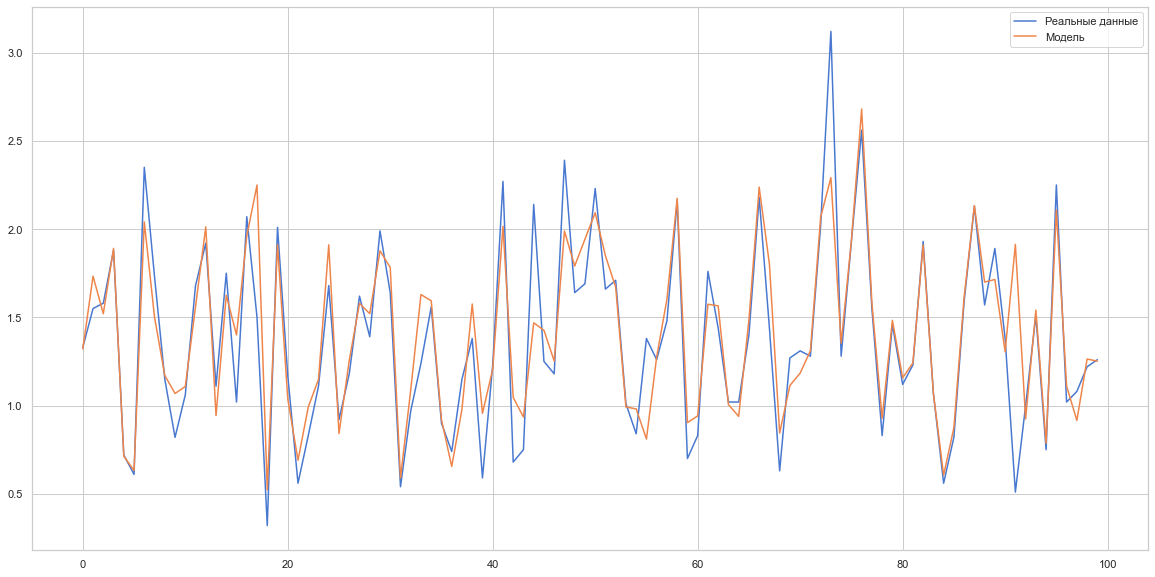

In [35]:
plt.figure(figsize=(20,10))

plt.plot(y_test.values[1500:1600], label='Реальные данные')
plt.plot(pred[1500:1600], label='Модель')

plt.legend()
plt.show();

Посмотрим, какие признаки больше всего влияют на модель.

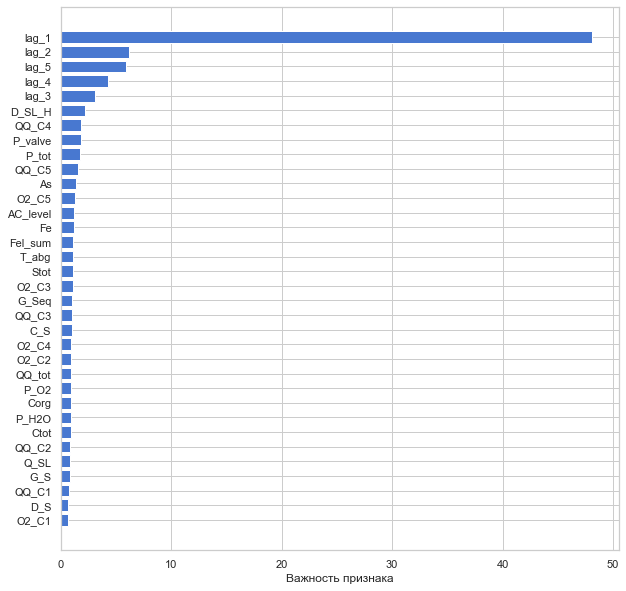

In [23]:
sorted_feature_importance = model.feature_importances_.argsort()

plt.figure(figsize=(10,10))
plt.barh(X_test.columns[sorted_feature_importance], model.feature_importances_[sorted_feature_importance])
plt.xlabel("Важность признака")
plt.show();

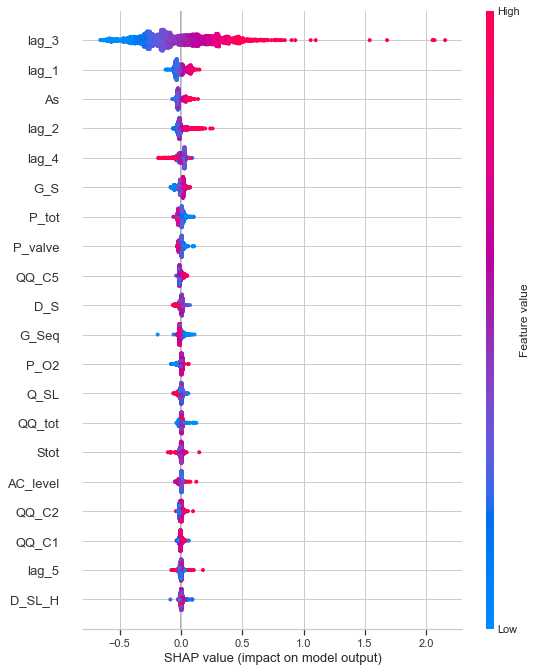

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names = X_test.columns[sorted_feature_importance])

In [65]:
params = {"iterations": 1000,
          "depth": 2,
          "loss_function": "MAE",
          "verbose": False}

cv_data = cb.Pool(X, y)

scores = cb.cv(cv_data, params, type="TimeSeries", fold_count=5, plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))